In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from tqdm import tqdm
import pandas
import numpy
import random
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

float_tensor_fn = torch.cuda.FloatTensor if torch.cuda.is_available else torch.FloatTensor

using cuda: NVIDIA GeForce RTX 3090


In [3]:
class MnistDataset(Dataset):
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        label = self.data_df.iloc[index, 0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        image_values = float_tensor_fn(self.data_df.iloc[index, 1:].values) / 255.0
        
        return label, image_values, target    
    
    def plot_image(self, index):
        arr = self.data_df.iloc[index, 1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index, 0]))
        plt.imshow(arr, interpolation='none', cmap='Blues')
        pass

In [4]:
mnist_dataset = MnistDataset('./dataset/mnist/mnist_train.csv')

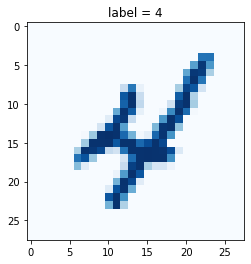

In [5]:
mnist_dataset.plot_image(9)

## Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(784 + 10, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 1),
            nn.Sigmoid()        
        )

        self.loss_function = nn.BCELoss()

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []
        pass
    
    def forward(self, image_tensor, label_tensor):
        inputs = torch.cat((image_tensor, label_tensor))
        return self.model(inputs)
    
    
    def train(self, inputs, label_tensor, targets):
        outputs = self.forward(inputs, label_tensor)
        
        loss = self.loss_function(outputs, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        pass
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(100 + 10, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        
        self.counter = 0
        self.progress = []
        
    def forward(self, seed_tensor, label_tensor):        
        inputs = torch.cat((seed_tensor, label_tensor))
        return self.model(inputs)


    def train(self, D, inputs, label_tensor, targets):
        g_output = self.forward(inputs, label_tensor)
        d_output = D.forward(g_output, label_tensor)
        
        loss = D.loss_function(d_output, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        pass
    
    def plot_images(self, label):
        label_tensor = torch.zeros((10))
        label_tensor[label] = 1.0
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(G.forward(generate_random_seed(100), label_tensor).detach().cpu().numpy().reshape(28,28), interpolation='none', cmap='Blues')
                pass
            pass
        pass     
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass    

In [8]:
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    random_idx = random.randint(0,size-1)
    label_tensor[random_idx] = 1.0
    return label_tensor

In [9]:
%%time

D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

for epoch in tqdm(range(10)):
    print ("epoch = ", epoch + 1)

    for label, image_data_tensor, label_tensor in mnist_dataset:
        # Train 'true' images
        D.train(image_data_tensor, label_tensor, float_tensor_fn([1.0]))
        
        random_label = generate_random_one_hot(10)

        # Train 'false'
        D.train(G.forward(generate_random_seed(100), random_label).detach(), random_label, float_tensor_fn([0.0]))

        random_label = generate_random_one_hot(10)
        
        # Train Generator
        G.train(D, generate_random_seed(100), random_label, float_tensor_fn([1.0]))

        pass

  0%|                                                                                                                                                                                                                                                                                                | 0/10 [00:00<?, ?it/s]

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000


 10%|███████████████████████████▉                                                                                                                                                                                                                                                           | 1/10 [04:28<40:17, 268.57s/it]

counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000


 20%|███████████████████████████████████████████████████████▊                                                                                                                                                                                                                               | 2/10 [08:57<35:50, 268.81s/it]

counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000


 30%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                   | 3/10 [13:28<31:28, 269.85s/it]

counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000


 40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 4/10 [17:56<26:54, 269.14s/it]

counter =  480000
epoch =  5
counter =  490000
counter =  500000
counter =  510000
counter =  520000
counter =  530000
counter =  540000
counter =  550000
counter =  560000
counter =  570000
counter =  580000
counter =  590000


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 5/10 [22:24<22:23, 268.71s/it]

counter =  600000
epoch =  6
counter =  610000
counter =  620000
counter =  630000
counter =  640000
counter =  650000
counter =  660000
counter =  670000
counter =  680000
counter =  690000
counter =  700000
counter =  710000


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 6/10 [26:52<17:53, 268.40s/it]

counter =  720000
epoch =  7
counter =  730000
counter =  740000
counter =  750000
counter =  760000
counter =  770000
counter =  780000
counter =  790000
counter =  800000
counter =  810000
counter =  820000
counter =  830000


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 7/10 [31:20<13:25, 268.45s/it]

counter =  840000
epoch =  8
counter =  850000
counter =  860000
counter =  870000
counter =  880000
counter =  890000
counter =  900000
counter =  910000
counter =  920000
counter =  930000
counter =  940000
counter =  950000


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 8/10 [35:49<08:56, 268.42s/it]

counter =  960000
epoch =  9
counter =  970000
counter =  980000
counter =  990000
counter =  1000000
counter =  1010000
counter =  1020000
counter =  1030000
counter =  1040000
counter =  1050000
counter =  1060000
counter =  1070000


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 9/10 [40:17<04:28, 268.44s/it]

counter =  1080000
epoch =  10
counter =  1090000
counter =  1100000
counter =  1110000
counter =  1120000
counter =  1130000
counter =  1140000
counter =  1150000
counter =  1160000
counter =  1170000
counter =  1180000
counter =  1190000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [44:46<00:00, 268.62s/it]

counter =  1200000
Wall time: 44min 47s


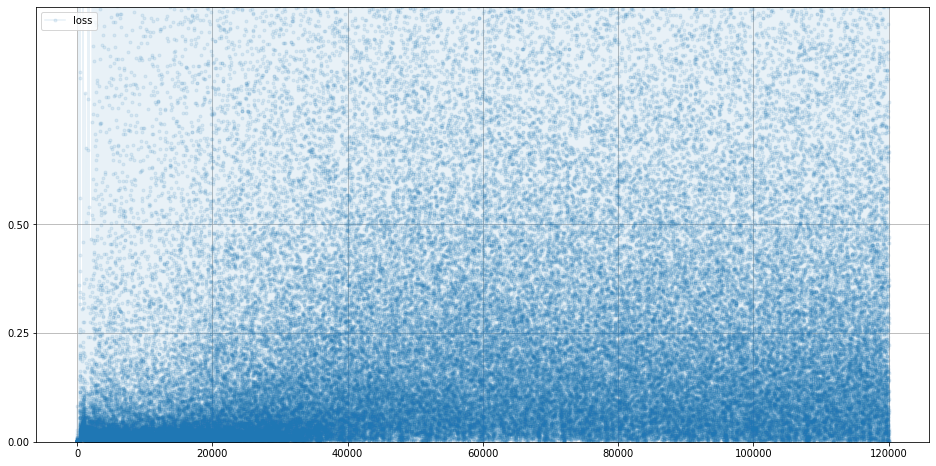

In [10]:
D.plot_progress()

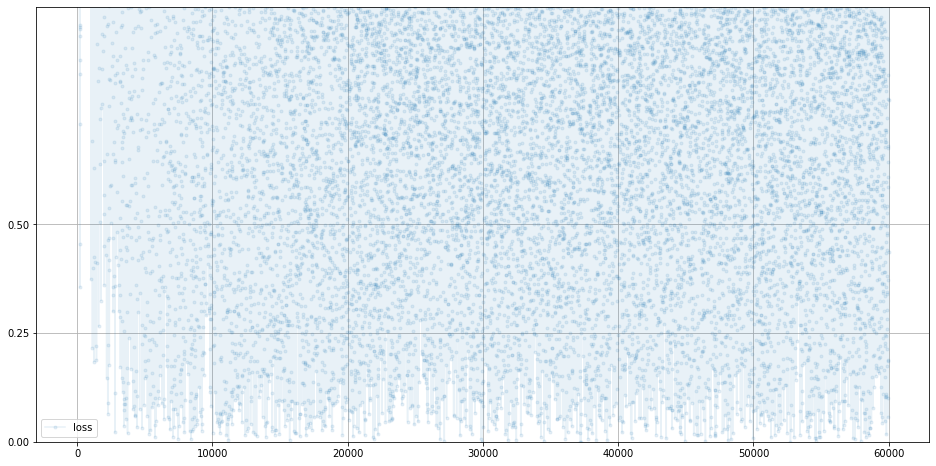

In [11]:
G.plot_progress()

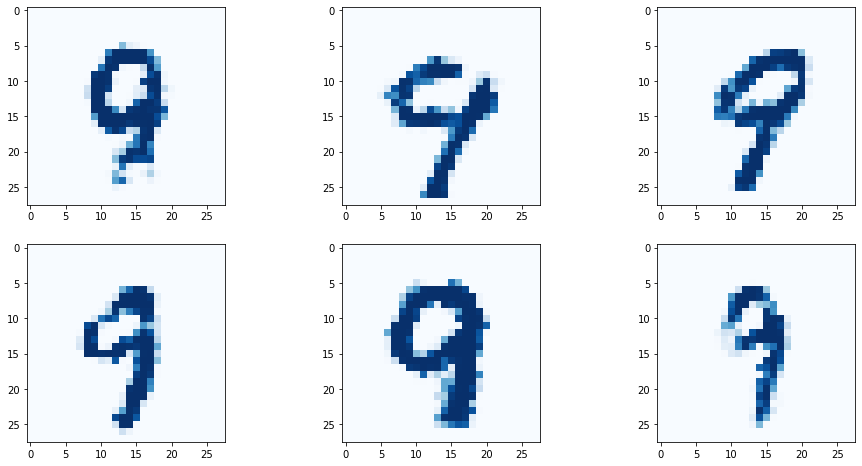

In [12]:
G.plot_images(9)    

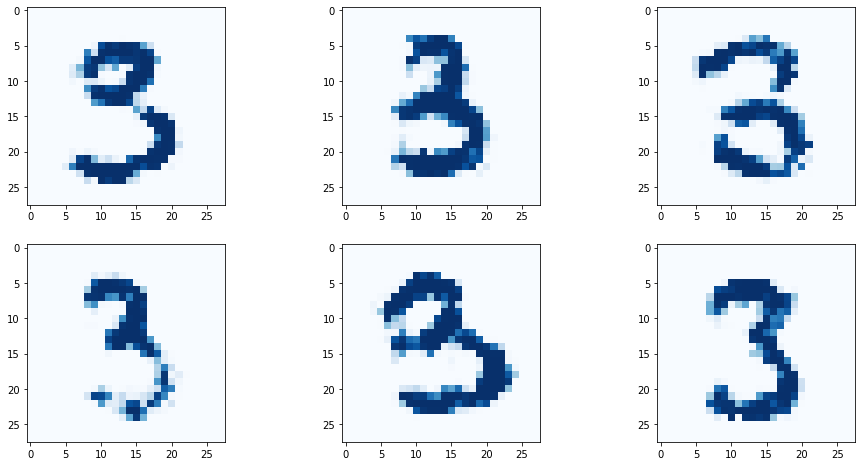

In [13]:
G.plot_images(3)